# Deep Learning (RNN model)

## Imports

In [21]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf

In [2]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/home/galinasamotorova/code/GalinaSa/Final-Project'

## Import the data

In [202]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = 'data'
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [203]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


In [204]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

## Data cleaning

### Drop features with all NaN and >30% NaN values

In [205]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)
df.shape

(5813, 65)

### Drop features with std = 0

In [206]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

df.shape

(5813, 41)

### Drop corrected, 'choke' and correlated features, and from 'remove' dict

In [207]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

In [208]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

In [209]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P']
df.drop(columns=features_corr_drop, inplace = True)

In [210]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P", "Service Line P", "Manifold T", "Jumper T"}
df.drop(columns=remove, inplace=True)

In [211]:
df.shape

(5813, 16)

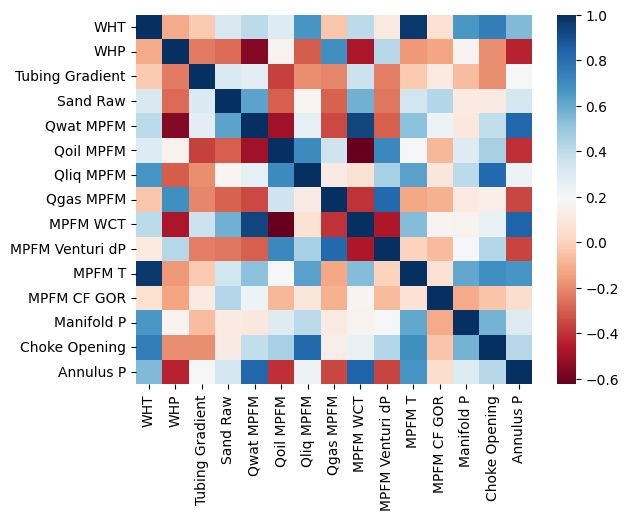

In [212]:
# Pairwise correlation
sns.heatmap(df.corr(), cmap='RdBu')
plt.show()

## Impute features

In [213]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [214]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Sand Raw           0
Qwat MPFM          0
Qoil MPFM          0
Qliq MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold P         0
Choke Opening      0
Annulus P          0
dtype: int64

In [215]:
df.head()

,Date,WHT,WHP,Tubing Gradient,Sand Raw,Qwat MPFM,Qoil MPFM,Qliq MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold P,Choke Opening,Annulus P
0,2007-02-01,51.247467,78.146263,0.0,5084.182129,12960.072938,14065.431937,26572.03904,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
1,2007-02-02,51.247467,78.146263,0.0,5084.182129,12960.072938,14065.431937,26572.03904,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
2,2007-02-03,51.247467,78.146263,0.0,5084.182129,12960.072938,14065.431937,26572.03904,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
3,2007-02-04,51.247467,78.146263,0.0,5084.182129,12960.072938,14065.431937,26572.03904,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
4,2007-02-05,51.247467,78.146263,0.0,5084.182129,12960.072938,14065.431937,26572.03904,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353


## Feature selection

In [111]:
# starting the first model with 6 features only + our Target 'Qoil MPFM':

df_f = df[["Qoil MPFM","MPFM WCT", "Qliq MPFM", "WHT", "WHP"]].copy()

In [112]:
df_f.shape

(5813, 7)

In [113]:
df_f

,Qoil MPFM,MPFM WCT,Annulus P,Tubing Gradient,WHT,WHP,Choke Opening
0,14065.431937,0.000000,150.246353,0.000000,51.247467,78.146263,76.917267
1,14065.431937,0.000000,150.246353,0.000000,51.247467,78.146263,76.917267
2,14065.431937,0.000000,150.246353,0.000000,51.247467,78.146263,76.917267
3,14065.431937,0.000000,150.246353,0.000000,51.247467,78.146263,76.917267
4,14065.431937,0.000000,150.246353,0.000000,51.247467,78.146263,76.917267
...,...,...,...,...,...,...,...
5808,10925.670806,66.457010,147.032196,1.003753,51.966740,65.511459,72.995338
5809,11142.564473,65.386773,147.082047,1.003906,51.968021,65.433243,72.484528
5810,11140.120568,65.647569,147.067032,1.005642,51.972717,65.115013,73.002724
5811,11400.139595,64.967486,147.128189,1.006597,51.982071,64.796227,72.730721


In [114]:
df_f.describe()

,Qoil MPFM,MPFM WCT,Annulus P,Tubing Gradient,WHT,WHP,Choke Opening
count,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000
mean,15655.948879,38.143842,139.765149,0.681469,48.902811,82.228238,76.908024
std,8820.271696,24.478523,24.254480,0.431681,8.115710,18.409271,19.746536
min,0.000000,-0.605886,18.328125,-1.163743,2.044475,1.013250,-0.251513
25%,9795.177134,12.084156,114.992844,0.581442,49.808365,73.542336,71.080894
50%,14065.431937,49.305413,150.246353,0.813119,51.247467,78.146263,76.917267
75%,18393.306228,59.913923,157.666885,0.971290,51.697182,82.110954,89.220985
max,49223.595339,91.660984,168.035065,2.267137,52.393002,216.446396,101.011047


## Visualizing Time Series

In [115]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df_f.shape[1] - 1

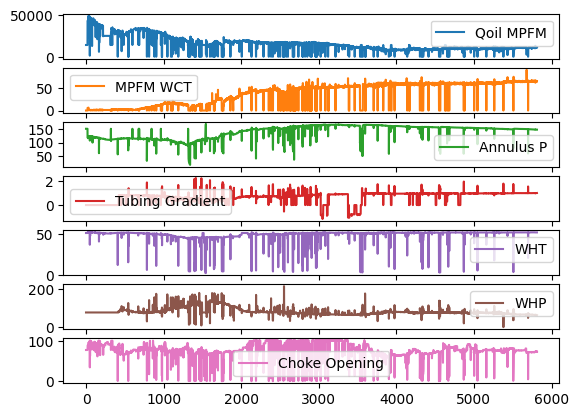

In [117]:
plot_cols = [TARGET, "MPFM WCT", "Annulus P", "Tubing Gradient", "WHT", "WHP","Choke Opening"]
plot_features = df_f[plot_cols]
plot_features.index = df_f.index
plot_features.plot(subplots = True);

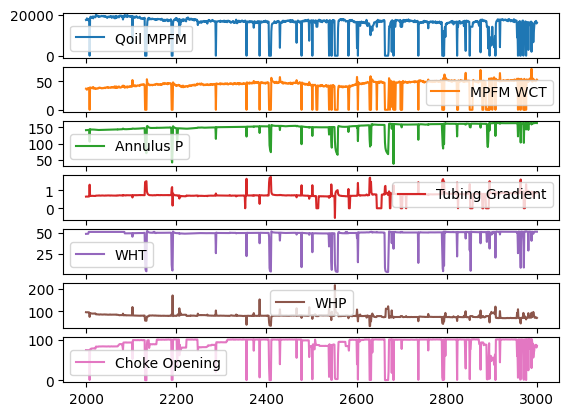

In [118]:
zoomed_slice = slice(2000,3000)

plot_features = df_f.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Preparing the dataset

In [24]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 9 # nine years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 3 months

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [25]:
def get_folds(
    df_f: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df_f), fold_stride):
        if i + fold_length >= len(df_f):
            break
        fold_list.append(df_f[i:fold_length])
    
    return fold_list

In [26]:
folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 28 folds.
Each fold has a shape equal to (3285, 7).


### Temporal Train/Test split

Let's focus on one fold

In [27]:
fold = folds[0]
fold

,Qoil MPFM,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
0,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
1,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
2,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
3,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
4,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
...,...,...,...,...,...,...,...
3280,13847.190782,53.188693,164.850006,1765.942017,51.658119,65.955971,100.092194
3281,13805.912747,53.813445,164.846222,1798.200317,51.588806,66.075676,100.254662
3282,14022.647480,52.981063,164.897873,1781.037720,51.621613,66.310822,100.330078
3283,13517.461733,54.374691,164.915909,1801.078979,51.593250,66.022469,100.383385


☝️ We want to split this fold chronologically into:

- train dataframe
- test dataframe

that will contain all the data we need to be able to sample many (X_i, y_i) pairs in each dataframe in a next step!

The INPUT_LENGTH of each X_i is going to be equal to 2 weeks (*but we can change it*)

In [28]:
INPUT_LENGTH = 14 # two weeks

In [29]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [30]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [31]:
print(f'Each fold has a shape equal to {fold.shape}.')
print(f'Each fold_train has a shape equal to {fold_train.shape}.')
print(f'Each fold_test has a shape equal to {fold_test.shape}.')

Each fold has a shape equal to (3285, 7).
Each fold_train has a shape equal to (2168, 7).
Each fold_test has a shape equal to (1131, 7).


### Create (X, y) sequences

Now that we have splitted our fold into a train set and a test set, it is time to:

- sample lots of sequences (Xi,yi) on which the model will be trained
- sample lots of sequences (Xi,yi)on which the model will be evaluated

Our goal is to create 3D-arrays (X_train, y_train) and (X_test, y_test) containing all the SEQUENCES we need from this fold:

- X_train.shape = (n_samples_train, input_length, n_features)
- y_train.shape = (n_samples_train, output_length, n_targets)

In [32]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 6
INPUT_LENGTH = 14 days = 2 weeks


X is the input of our model.

- It contains 7 features: the past values of the target + 6 past-covariates
- Each sequence has a length equal to 2 weeks

In [33]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


y is the target that we want to predict

- It is the value at the single next timestep (= next day)
 - We could also predict OUTPUT_LENGTH > 1, i.e several values in the future (2, 3 days later,...) but let's keep it simple here and just try to predict the next point (next day)

### Creating the (X,y) sequences by random sampling in each fold

Generating one random sequence

In [34]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [35]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [36]:
X_train_i.shape

(14, 7)

In [37]:
# Advanced check 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

Generating multiple random sequence

In [38]:
SEQUENCE_STRIDE = 1 #temporal stride of 1 day

In [39]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [40]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 3285 days
= 469 weeks


In [41]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(2153, 14, 7)
(2153, 1, 1)


## DL Modeling

### Baseline Model : predict the "last seen value" to compare with our LSTM

In [42]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization

def init_baseline():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [43]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {baseline_score[1]} barrels")

2023-03-22 09:40:14.884286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 09:40:14.884704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 09:40:14.884870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-22 09:40:14.885132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-22 09:40:14.885253: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

35/35 [==============================] - 0s 2ms/step - loss: 240270608.0000 - mae: 14995.3125
- The Baseline MAE on the test set is equal to 14995.3125 barrels


### RNN : the LSTM - first attempts

In [196]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [51]:
def init_model(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(256, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [52]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 7)          15        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 256)               270336    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 270,608
Trainable params: 270,593
Non-trainable params: 15
_________________________________________________________________


In [53]:
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, List, Tuple, Sequence

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [54]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 7)          15        
 ion)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 256)               270336    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 270,608
Trainable params: 270,593
Non-trainable params: 15
_________________________________________________________________
Epoch 1/120
95/95 [==============================] - 5s 37ms/step - loss: 774353216.0000 - mae: 26135.0117 - val_loss: 267604112.0000 - val_mae: 15712.2480
Epoch 2/120
95/95 [==============================] - 3s 35ms/step - loss: 755893248.0000 

Epoch 48/120
95/95 [==============================] - 2s 26ms/step - loss: 214103184.0000 - mae: 12728.1104 - val_loss: 22369456.0000 - val_mae: 3267.9075
Epoch 49/120
95/95 [==============================] - 2s 25ms/step - loss: 208301808.0000 - mae: 12527.0986 - val_loss: 22143680.0000 - val_mae: 3178.8740
Epoch 50/120
95/95 [==============================] - 2s 23ms/step - loss: 204260464.0000 - mae: 12382.3154 - val_loss: 22073352.0000 - val_mae: 3130.1301
Epoch 51/120
95/95 [==============================] - 2s 24ms/step - loss: 201957584.0000 - mae: 12299.9600 - val_loss: 21871990.0000 - val_mae: 3025.4500
Epoch 52/120
95/95 [==============================] - 2s 26ms/step - loss: 196592848.0000 - mae: 12104.3887 - val_loss: 21984682.0000 - val_mae: 2920.2275
Epoch 53/120
95/95 [==============================] - 2s 25ms/step - loss: 191412496.0000 - mae: 11910.6758 - val_loss: 22137370.0000 - val_mae: 2826.5903
Epoch 54/120
95/95 [==============================] - 2s 26ms/step - l

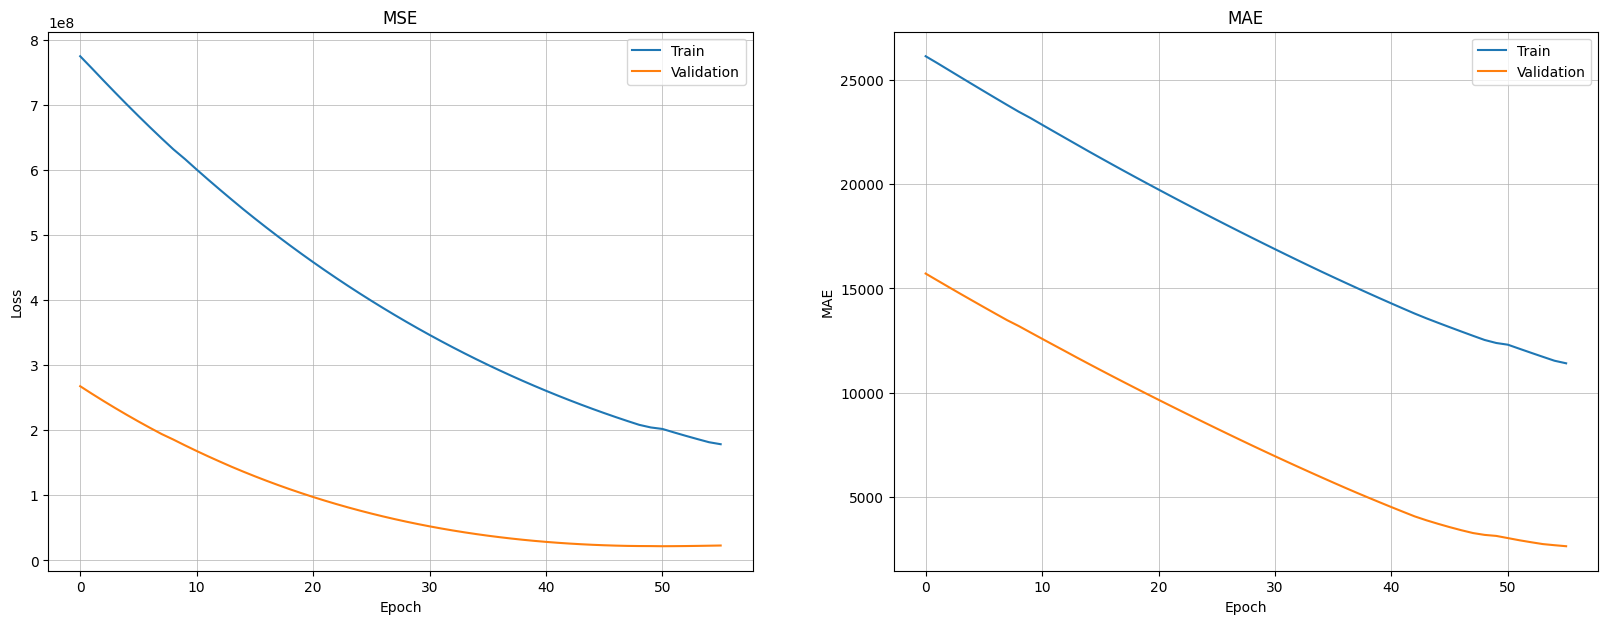

In [55]:
plot_history(history);

In [56]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res[1]} barrels")

35/35 [==============================] - 0s 12ms/step - loss: 16310026.0000 - mae: 1932.5211
The LSTM MAE on the test set is equal to 1932.5211181640625 barrels


In [57]:
print(f"- The LSTM MAE on the test set is equal to {res[1]} barrels")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 1932.5211181640625 barrels
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 87.11 % 🔥


### Cross-Validation

In [287]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}') 
print(f'N_TARGETS = {N_TARGETS}') 
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')

print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 6
N_TARGETS = 1

FOLD_LENGTH = 3285
FOLD_STRIDE = 91
TRAIN_TEST_RATIO = 0.66

INPUT_LENGTH = 14
OUTPUT_LENGTH = 1


In [288]:
#  how many folds we have 
folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)

print(f" we have {len(folds)} FOLDS")

 we have 28 FOLDS


In [289]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 5, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 16,
                            epochs = 100,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [290]:
%%time
# WARNING : it takes 2-3 hours to run this cell 
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

--------------------------------------------------
MAE baseline fold n°0 = 14995.31
MAE LSTM fold n°0 = 7557.64
🏋🏽‍♂️ improvement over baseline: 49.6 % 

--------------------------------------------------
MAE baseline fold n°1 = 14980.55
MAE LSTM fold n°1 = 3274.64
🏋🏽‍♂️ improvement over baseline: 78.14 % 

--------------------------------------------------
MAE baseline fold n°2 = 14918.11
MAE LSTM fold n°2 = 13958.72
🏋🏽‍♂️ improvement over baseline: 6.43 % 

--------------------------------------------------
MAE baseline fold n°3 = 14855.89
MAE LSTM fold n°3 = 2791.66
🏋🏽‍♂️ improvement over baseline: 81.21 % 

--------------------------------------------------
MAE baseline fold n°4 = 14814.62
MAE LSTM fold n°4 = 1938.88
🏋🏽‍♂️ improvement over baseline: 86.91 % 

--------------------------------------------------
MAE baseline fold n°5 = 14756.38
MAE LSTM fold n°5 = 2648.4
🏋🏽‍♂️ improvement over baseline: 82.05 % 

--------------------------------------------------
MAE baseline fold n°6

In [291]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 65.0%


In [58]:
X_test.shape, y_test.shape

((1116, 14, 7), (1116, 1, 1))

In [59]:
features = pd.DataFrame(X_test[:,0],
                 columns=["Qoil MPFM Real","MPFM WCT", "Annulus P", "Tubing Gradient", "WHT", "WHP","Choke Opening"])
features

,Qoil MPFM Real,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
0,17314.554926,44.993297,148.336685,4600.971191,49.920815,80.451302,88.408333
1,17670.793776,44.491959,148.471054,4698.059082,49.928555,80.789749,88.678017
2,17453.841372,44.681557,148.501297,4479.698242,49.951077,79.934982,88.353958
3,17556.162896,45.533877,149.328171,4418.763672,50.314072,80.147614,99.758553
4,17498.254331,44.968968,148.816071,4383.696777,50.182426,79.850708,99.712387
...,...,...,...,...,...,...,...
1111,14368.789387,51.954152,165.297897,1829.494751,51.586681,66.296234,100.408653
1112,13973.439999,53.228272,165.299210,1828.518921,51.590042,66.345024,100.386848
1113,13826.439474,53.326576,165.268906,1738.906250,51.630058,66.528564,100.289116
1114,13874.553993,53.525749,165.220566,1783.643555,51.616470,66.313080,100.693344


In [60]:
oil_r = features[["Qoil MPFM Real"]].copy()
oil_r

,Qoil MPFM Real
0,17314.554926
1,17670.793776
2,17453.841372
3,17556.162896
4,17498.254331
...,...
1111,14368.789387
1112,13973.439999
1113,13826.439474
1114,13874.553993


In [61]:
# 4 - Prediction
# ====================================
y_pred = model.predict(X_test)
y_pred.shape

35/35 [==============================] - 1s 9ms/step


(1116, 1)

In [62]:
prediction = pd.DataFrame(y_pred, columns =['Qoil Predicted'])
prediction

,Qoil Predicted
0,15927.236328
1,15927.201172
2,15927.124023
3,15927.015625
4,15926.847656
...,...
1111,15931.810547
1112,15931.769531
1113,15931.915039
1114,15931.868164


<AxesSubplot:>

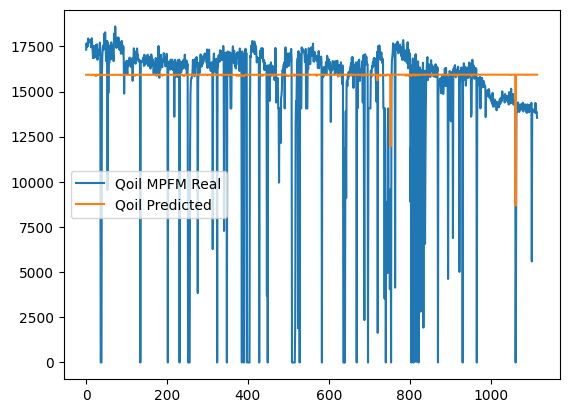

In [63]:
results=pd.concat([oil_r,prediction],axis=1)
results.plot()

### RNN : the LSTM going further (Dropout layer, Batch Normalization, more layers) -NO IMPROVEMENT

In [82]:
def init_model_2(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer + Dropout layer
    model.add(layers.LSTM(128, 
                          activation='tanh', 
                          return_sequences = True,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(256, activation='tanh',return_sequences = True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(128, activation='tanh'))
    
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [83]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, None, 7)          15        
 ion)                                                            
                                                                 
 lstm_7 (LSTM)               (None, None, 128)         69632     
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         394240    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)       

In [84]:
def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [85]:
model_2, history_2 = fit_model(model_2)

Epoch 1/120
95/95 [==============================] - 6s 36ms/step - loss: 778632448.0000 - mae: 26218.2012 - val_loss: 272953184.0000 - val_mae: 15862.6748
Epoch 2/120
95/95 [==============================] - 3s 29ms/step - loss: 768903168.0000 - mae: 26045.3750 - val_loss: 267189744.0000 - val_mae: 15699.7832
Epoch 3/120
95/95 [==============================] - 3s 29ms/step - loss: 758282688.0000 - mae: 25856.4004 - val_loss: 264592576.0000 - val_mae: 15618.6396
Epoch 4/120
95/95 [==============================] - 3s 29ms/step - loss: 747897024.0000 - mae: 25670.3828 - val_loss: 259897744.0000 - val_mae: 15479.3750
Epoch 5/120
95/95 [==============================] - 3s 27ms/step - loss: 737707392.0000 - mae: 25486.3906 - val_loss: 255264976.0000 - val_mae: 15340.4131
Epoch 6/120
95/95 [==============================] - 3s 28ms/step - loss: 727664064.0000 - mae: 25303.7949 - val_loss: 250684944.0000 - val_mae: 15202.6699
Epoch 7/120
95/95 [==============================] - 3s 27ms/ste

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

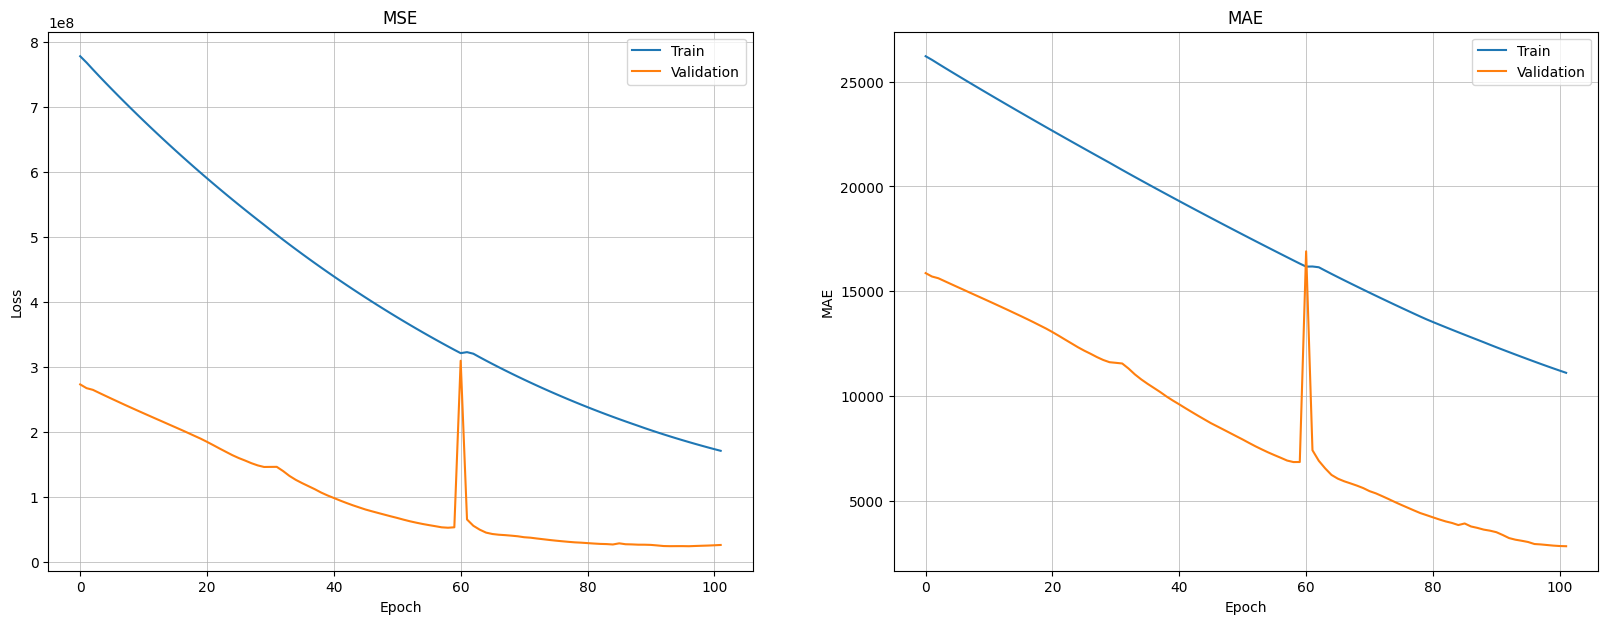

In [86]:
plot_history(history_2)

In [87]:
# 3 - Evaluation
# ====================================
res_2 = model_2.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res_2[1]} barrels")

35/35 [==============================] - 0s 13ms/step - loss: 18533652.0000 - mae: 1983.3898
The LSTM MAE on the test set is equal to 1983.3897705078125 barrels


In [88]:
print(f"- The LSTM MAE on the test set is equal to {res_2[1]} barrels")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res_2[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 1983.3897705078125 barrels
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 86.77 % 🔥


35/35 [==============================] - 0s 11ms/step


<AxesSubplot:>

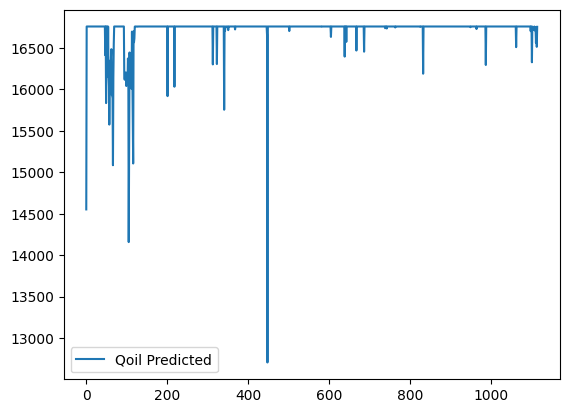

In [91]:
y_pred_2 = model_2.predict(X_test)
prediction_2 = pd.DataFrame(y_pred_2, columns =['Qoil Predicted'])
prediction_2.plot()

### RNN : the LSTM (changed optimizer to SGD) - slight improvement in MAE, but Y_PRED is constant :(

In [115]:
def init_model_sgd(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer + Dropout layer
    model.add(layers.LSTM(256, 
                          activation='tanh', 
                          return_sequences = True,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.LSTM(128, activation='tanh'))
    
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    sgd = optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=1)    
    model.compile(loss='mse', optimizer=sgd, metrics=["mae"])
    
    return model

In [116]:
model_sgd = init_model_sgd(X_train, y_train)
model_sgd.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, None, 7)          15        
 tion)                                                           
                                                                 
 lstm_16 (LSTM)              (None, None, 256)         270336    
                                                                 
 batch_normalization_5 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               197120    
                                                                 
 dense_10 (Dense)            (None, 1)               

In [117]:
def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 10,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [118]:
model_sgd, history_sgd = fit_model(model_sgd)

Epoch 1/120
95/95 [==============================] - 5s 28ms/step - loss: 762378688.0000 - mae: 25888.9082 - val_loss: 246275264.0000 - val_mae: 15098.2832
Epoch 2/120
95/95 [==============================] - 2s 22ms/step - loss: 705009792.0000 - mae: 24839.9629 - val_loss: 213061600.0000 - val_mae: 14088.4365
Epoch 3/120
95/95 [==============================] - 2s 22ms/step - loss: 649401856.0000 - mae: 23781.4473 - val_loss: 182507488.0000 - val_mae: 13086.0107
Epoch 4/120
95/95 [==============================] - 2s 22ms/step - loss: 596454336.0000 - mae: 22725.3691 - val_loss: 154613104.0000 - val_mae: 12089.9023
Epoch 5/120
95/95 [==============================] - 2s 22ms/step - loss: 546166208.0000 - mae: 21670.9180 - val_loss: 129378472.0000 - val_mae: 11093.7969
Epoch 6/120
95/95 [==============================] - 2s 22ms/step - loss: 498548608.0000 - mae: 20621.8125 - val_loss: 107083672.0000 - val_mae: 10116.0713
Epoch 7/120
95/95 [==============================] - 2s 21ms/ste

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

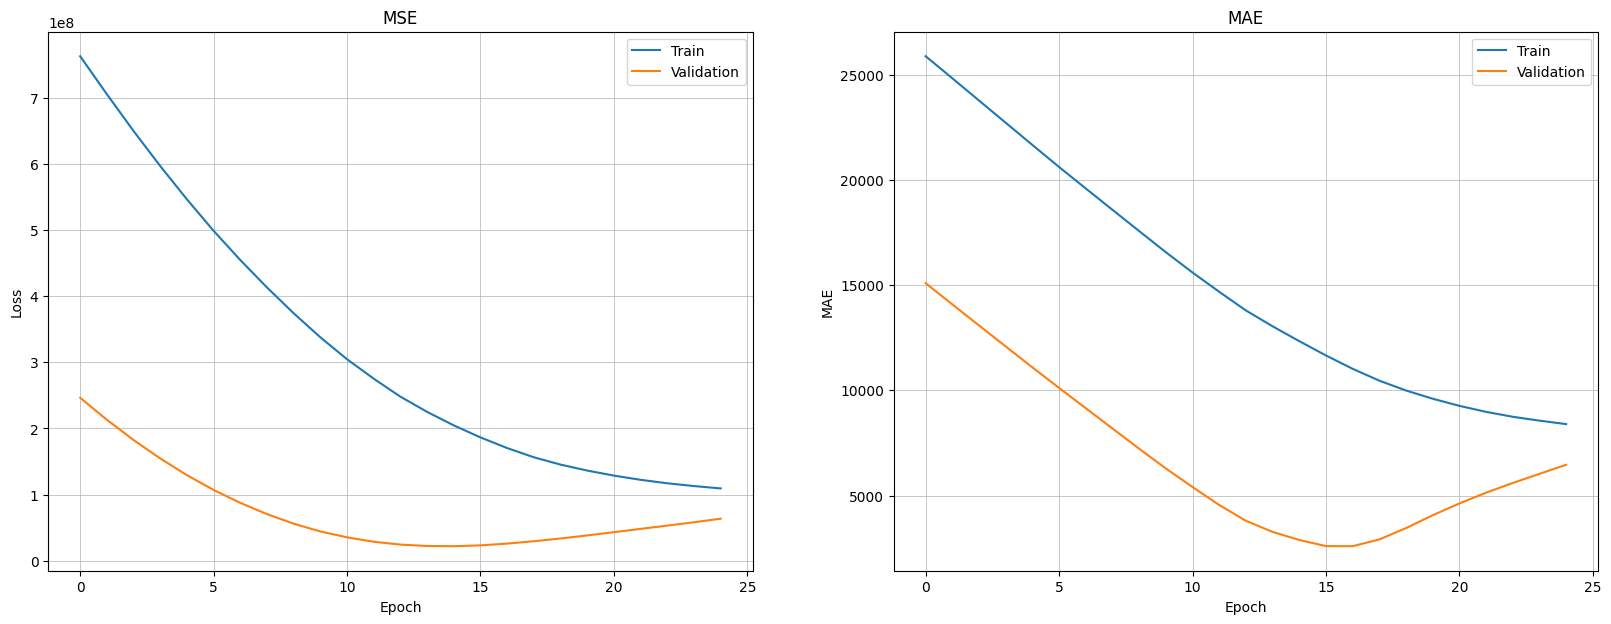

In [119]:
plot_history(history_sgd)

In [120]:
# 3 - Evaluation
# ====================================
res_sgd = model_sgd.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res_sgd[1]} barrels")

35/35 [==============================] - 0s 8ms/step - loss: 17077488.0000 - mae: 1864.8456
The LSTM MAE on the test set is equal to 1864.8455810546875 barrels


35/35 [==============================] - 1s 8ms/step


<AxesSubplot:>

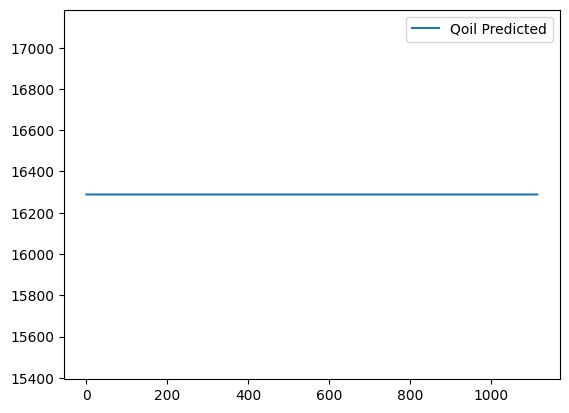

In [121]:
y_pred_sgd = model_sgd.predict(X_test)
prediction_sgd = pd.DataFrame(y_pred_sgd, columns =['Qoil Predicted'])
prediction_sgd.plot()

### Back to basics: reduce noise / manually clean the data

In [216]:
# starting the first model with 6 features only + our Target 'Qoil MPFM'
# WARNING in this attempt I've replaced "MPFM Venturi dP" by "Tubing Gradient" feature

df_clean = df[["Qoil MPFM","MPFM WCT", "Qliq MPFM", "WHT", "WHP"]].copy()
df_clean

,Qoil MPFM,MPFM WCT,Qliq MPFM,WHT,WHP
0,14065.431937,0.000000,26572.039040,51.247467,78.146263
1,14065.431937,0.000000,26572.039040,51.247467,78.146263
2,14065.431937,0.000000,26572.039040,51.247467,78.146263
3,14065.431937,0.000000,26572.039040,51.247467,78.146263
4,14065.431937,0.000000,26572.039040,51.247467,78.146263
...,...,...,...,...,...
5808,10925.670806,66.457010,32572.143637,51.966740,65.511459
5809,11142.564473,65.386773,32191.637342,51.968021,65.433243
5810,11140.120568,65.647569,32428.914925,51.972717,65.115013
5811,11400.139595,64.967486,32541.597131,51.982071,64.796227


In [222]:
df_clean['Qoil MPFM'].mask(df_clean['Qoil MPFM'].between(-1, 4000), inplace=True)
df_clean['MPFM WCT'].mask(df_clean['MPFM WCT'].between(-1, 1), inplace=True)
df_clean['Qliq MPFM'].mask(df_clean['Qliq MPFM'].between(-1, 10000), inplace=True)
df_clean['WHT'].mask(df_clean['WHT'].between(0, 44), inplace=True)
df_clean['WHP'].mask(df_clean['WHP'].between(0, 52), inplace=True)
df_clean['WHP'].mask(df_clean['WHP'].between(140, 230), inplace=True)


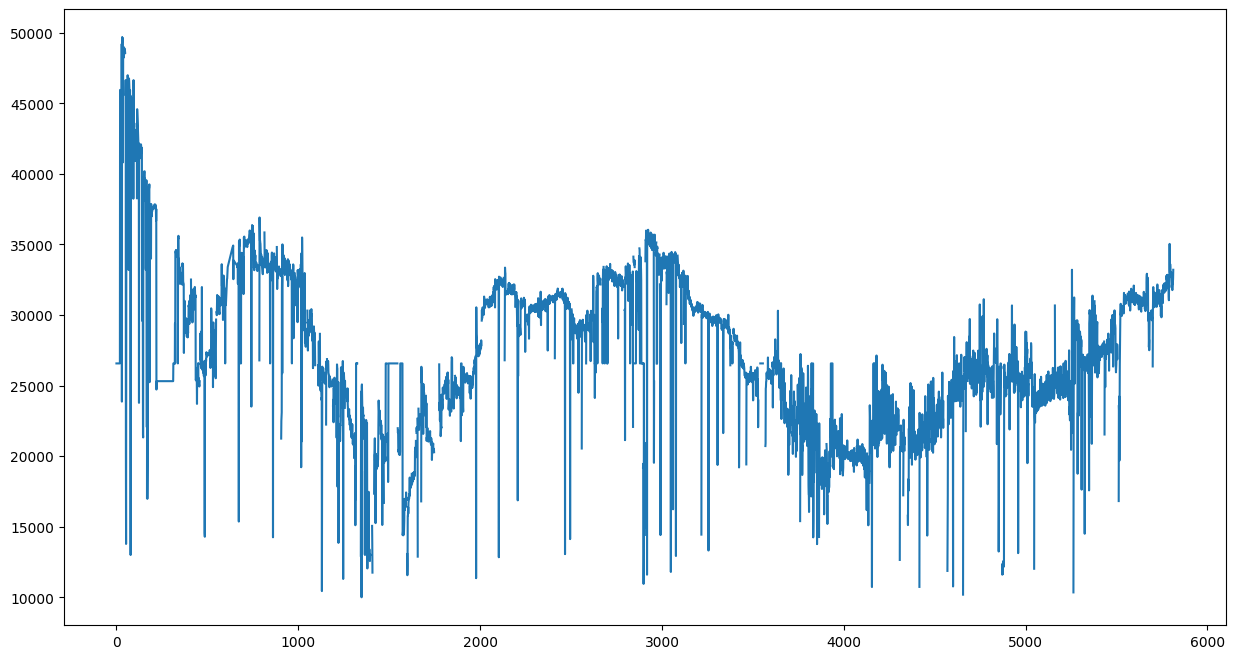

In [223]:
plt.figure(figsize=(15, 8))
plt.plot(df_clean['Qliq MPFM'])
plt.show();

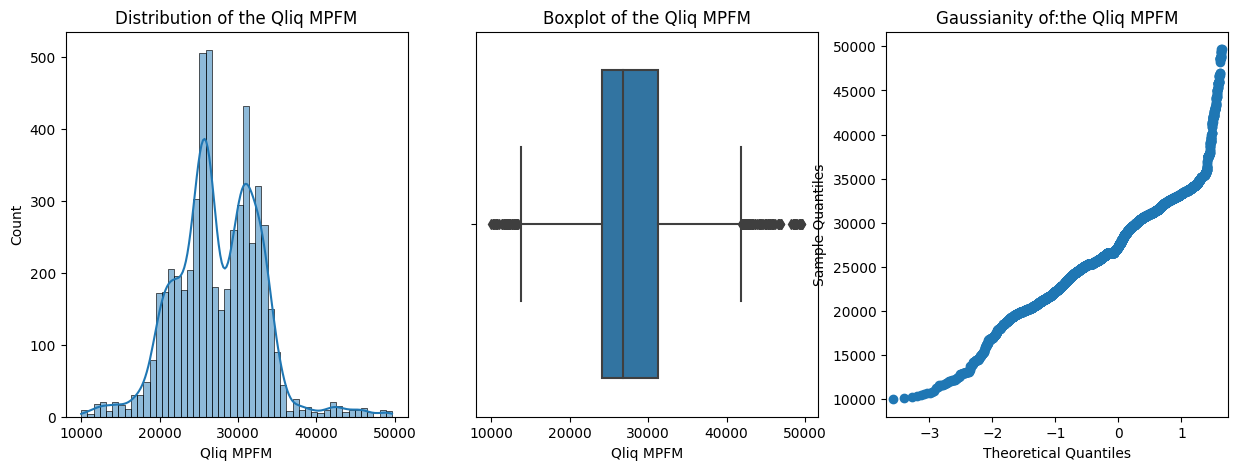

In [224]:
variable = 'Qliq MPFM'

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df_clean, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df_clean, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
sm.qqplot(df_clean[f"{variable}"],line='s',ax=ax[2]);


In [225]:
for feature in df_clean.columns:
    df_clean[feature].replace(np.nan, df_clean[feature].median(), inplace=True)

In [226]:
df_clean.isnull().sum()

Qoil MPFM    0
MPFM WCT     0
Qliq MPFM    0
WHT          0
WHP          0
dtype: int64

In [227]:
df_clean.describe()

,Qoil MPFM,MPFM WCT,Qliq MPFM,WHT,WHP
count,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000
mean,16344.569120,42.579947,27447.167563,50.518957,81.701123
std,8115.670259,21.743151,5322.260414,1.875052,15.354025
min,4062.757558,1.002506,10004.995528,44.263767,52.099525
25%,10175.329857,23.221134,24397.505978,50.179977,73.932274
50%,14345.377079,52.109728,26740.918674,51.311802,78.146263
75%,18393.306228,59.913923,31090.037056,51.697182,81.503654
max,49223.595339,91.660984,49676.388581,52.393002,139.956192


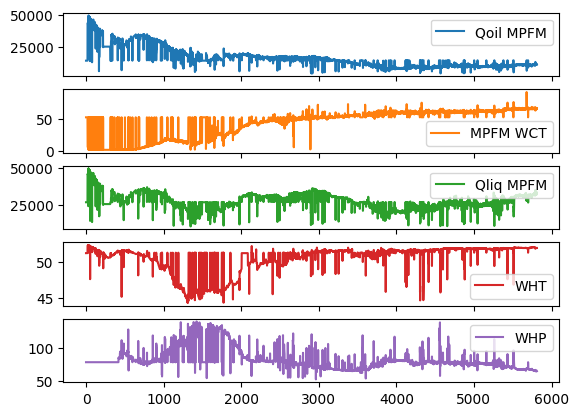

In [229]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df_clean.shape[1] - 1

plot_cols = [TARGET,"MPFM WCT", "Qliq MPFM", "WHT", "WHP"]
plot_features = df_clean[plot_cols]
plot_features.index = df_clean.index
plot_features.plot(subplots = True);

In [230]:
FOLD_LENGTH = 365 * 7 # seven years
FOLD_STRIDE = 91 # 3 months
TRAIN_TEST_RATIO = 0.66

In [231]:
def get_folds(
    df_clean: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
   
    fold_list = []
    
    for i in range(0, len(df_clean), fold_stride):
        if i + fold_length >= len(df_clean):
            break
        fold_list.append(df_clean[i:fold_length])
    
    return fold_list

In [232]:
folds = get_folds(df_clean, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 36 folds.
Each fold has a shape equal to (2555, 5).


In [233]:
fold = folds[0]
fold

,Qoil MPFM,MPFM WCT,Qliq MPFM,WHT,WHP
0,14065.431937,52.109728,26572.039040,51.247467,78.146263
1,14065.431937,52.109728,26572.039040,51.247467,78.146263
2,14065.431937,52.109728,26572.039040,51.247467,78.146263
3,14065.431937,52.109728,26572.039040,51.247467,78.146263
4,14065.431937,52.109728,26572.039040,51.247467,78.146263
...,...,...,...,...,...
2550,17148.121788,41.696902,29412.025079,49.594707,79.531380
2551,17015.530166,41.271305,28973.111534,49.587173,80.305725
2552,14345.377079,52.109728,26740.918674,51.311802,78.146263
2553,14345.377079,52.109728,26740.918674,51.311802,105.071236


In [234]:
INPUT_LENGTH = 14 # two weeks

In [235]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
   
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [236]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [237]:
print(f'Each fold has a shape equal to {fold.shape}.')
print(f'Each fold_train has a shape equal to {fold_train.shape}.')
print(f'Each fold_test has a shape equal to {fold_test.shape}.')

Each fold has a shape equal to (2555, 5).
Each fold_train has a shape equal to (1686, 5).
Each fold_test has a shape equal to (883, 5).


In [238]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 4
INPUT_LENGTH = 14 days = 2 weeks


In [239]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [240]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [241]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [242]:
X_train_i.shape

(14, 5)

In [243]:
# Advanced check 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [244]:
SEQUENCE_STRIDE = 1 #temporal stride of 1 day

In [245]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
   
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [246]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2555 days
= 365 weeks


In [247]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1671, 14, 5)
(1671, 1, 1)


#### DL modeling

Baseline Model

In [248]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization

def init_baseline_clean():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [249]:
baseline_model_clean = init_baseline_clean()
baseline_score_clean = baseline_model_clean.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {baseline_score_clean[1]} barrels")

28/28 [==============================] - 0s 1ms/step - loss: 294727488.0000 - mae: 17095.4688
- The Baseline MAE on the test set is equal to 17095.46875 barrels


LSTM 

In [191]:
def init_model_clean(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(256, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [192]:
model_clean = init_model_clean(X_train, y_train)
model_clean.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 7)          15        
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 256)               270336    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 270,608
Trainable params: 270,593
Non-trainable params: 15
_________________________________________________________________


In [193]:
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, List, Tuple, Sequence

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [194]:
model_clean, history_clean = fit_model(model_clean)

Epoch 1/120
74/74 [==============================] - 2s 16ms/step - loss: 916816320.0000 - mae: 29174.8945 - val_loss: 261582736.0000 - val_mae: 15135.0967
Epoch 2/120
74/74 [==============================] - 1s 13ms/step - loss: 901685440.0000 - mae: 28925.7012 - val_loss: 253225872.0000 - val_mae: 14904.4512
Epoch 3/120
74/74 [==============================] - 1s 12ms/step - loss: 885394944.0000 - mae: 28654.8574 - val_loss: 244408160.0000 - val_mae: 14653.1377
Epoch 4/120
74/74 [==============================] - 1s 12ms/step - loss: 867647488.0000 - mae: 28357.8789 - val_loss: 237702816.0000 - val_mae: 14433.4912
Epoch 5/120
74/74 [==============================] - 1s 12ms/step - loss: 851331264.0000 - mae: 28081.5645 - val_loss: 227137376.0000 - val_mae: 14142.2900
Epoch 6/120
74/74 [==============================] - 1s 12ms/step - loss: 834143808.0000 - mae: 27786.8711 - val_loss: 219545648.0000 - val_mae: 13892.0879
Epoch 7/120
74/74 [==============================] - 1s 12ms/ste

74/74 [==============================] - 1s 12ms/step - loss: 279518784.0000 - mae: 15433.6523 - val_loss: 34633400.0000 - val_mae: 4182.6338
Epoch 54/120
74/74 [==============================] - 1s 13ms/step - loss: 272276896.0000 - mae: 15210.7578 - val_loss: 34253920.0000 - val_mae: 4136.2466
Epoch 55/120
74/74 [==============================] - 1s 14ms/step - loss: 265200112.0000 - mae: 14989.3945 - val_loss: 33990796.0000 - val_mae: 4102.1431
Epoch 56/120
74/74 [==============================] - 1s 12ms/step - loss: 258286656.0000 - mae: 14769.5293 - val_loss: 33854884.0000 - val_mae: 4073.8743
Epoch 57/120
74/74 [==============================] - 1s 13ms/step - loss: 251534592.0000 - mae: 14551.1445 - val_loss: 33841752.0000 - val_mae: 4050.9641
Epoch 58/120
74/74 [==============================] - 1s 13ms/step - loss: 244942144.0000 - mae: 14334.0605 - val_loss: 33924704.0000 - val_mae: 4032.5237
Epoch 59/120
74/74 [==============================] - 1s 13ms/step - loss: 23850760

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

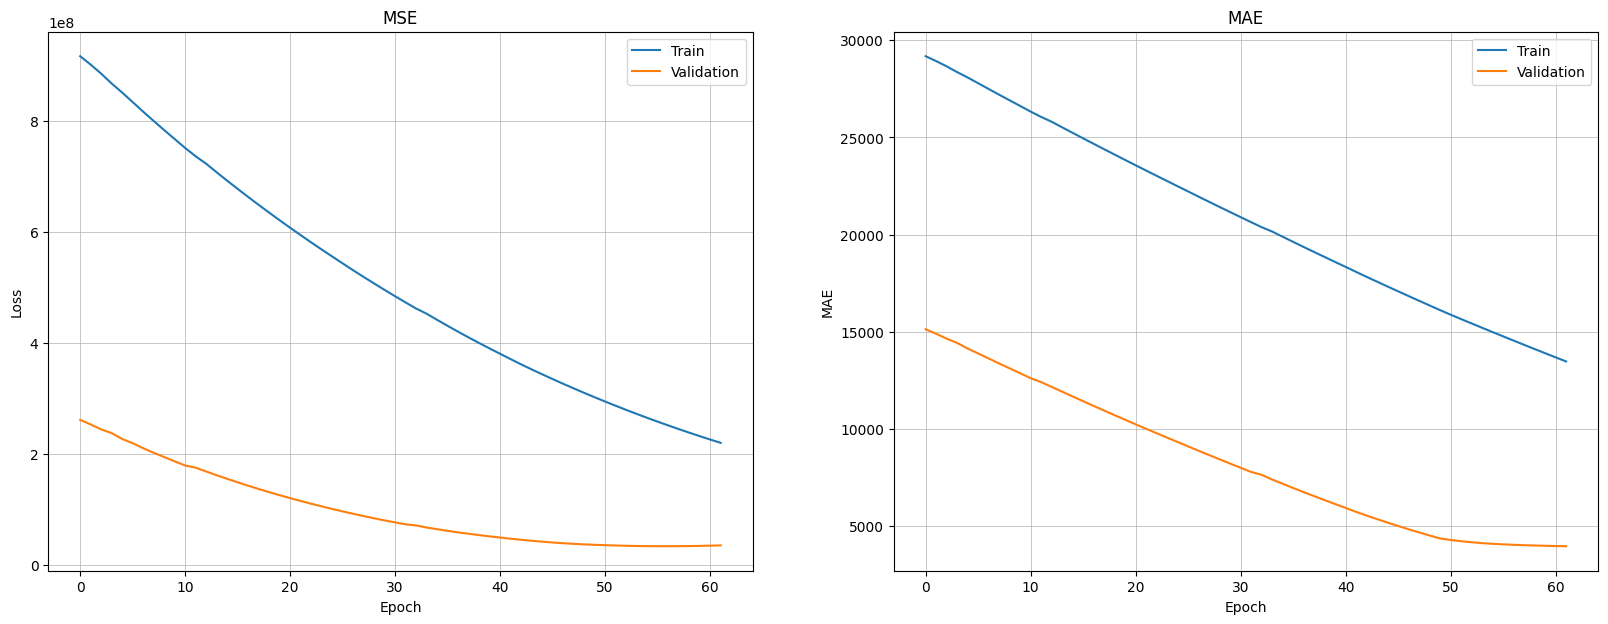

In [197]:
plot_history(history_clean)

In [198]:
res_clean = model_clean.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res_clean[1]} barrels")

28/28 [==============================] - 0s 5ms/step - loss: 16835824.0000 - mae: 2530.8740
The LSTM MAE on the test set is equal to 2530.8740234375 barrels


28/28 [==============================] - 0s 5ms/step


<AxesSubplot:>

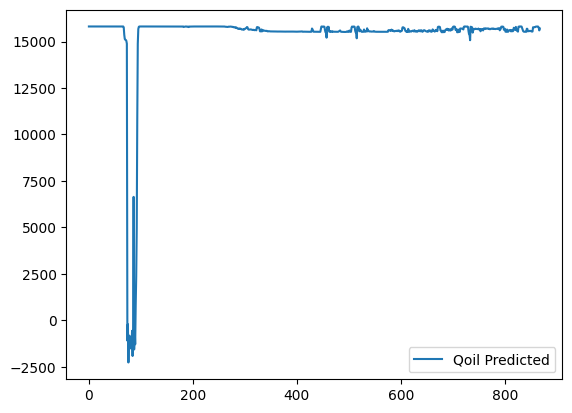

In [199]:
y_pred_clean = model_clean.predict(X_test)
prediction_clean = pd.DataFrame(y_pred_clean, columns =['Qoil Predicted'])
prediction_clean.plot()

## Exporting model

In [320]:
from tensorflow.keras import models

# Saving the model:
models.save_model(model, 'my_RNN_model')

# Loading the model:
#loaded_model = models.load_model('my_model')


INFO:tensorflow:Assets written to: my_RNN_model/assets


INFO:tensorflow:Assets written to: my_RNN_model/assets
